In [1]:
import torch

print(torch.__version__)

1.13.1+cu117


## Installation

In [ ]:
! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

## Visualization

In [77]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualization(h, color, epochs=None, loss=None, accuracy=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xticks([])
    ax.set_yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        ax.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap='Set2')
        if epochs is not None and \
            accuracy['train'] is not None and \
            accuracy['val'] is not None:
            ax.set_xlabel(
                f"Epochs: {epochs}, Loss: {loss.item()}\n" 
                f"Training Acc: {accuracy['train']*100:.2f}%\n"
                f"Validation Acc: {accuracy['val']*100:.2f}%",
            fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False, node_color=color, cmap='Set2')
    plt.show()

## Dataset

In [65]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print(f"Dataset: {dataset}:")
print('='*30)
print(f"Number of graph: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: KarateClub():
Number of graph: 1
Number of features: 34
Number of classes: 4


## data

In [66]:
data = dataset[0]

print(data)
print('='*40)

print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Edges: {data.num_edges}")
print(f"Avg degree: {2*data.num_edges / data.num_nodes:.2f}")
print(f"Number of trainning nodes: {data.train_mask.sum()}")
print(f"Trainning nodes ratio: {data.train_mask.sum() / data.num_nodes:.2f} %")
print(f"Contains isolation nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loop: {data.has_self_loops()}")
print(f"Graph is directed: {data.is_directed()}")

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of Nodes: 34
Number of Edges: 156
Avg degree: 9.18
Number of trainning nodes: 4
Trainning nodes ratio: 0.12 %
Contains isolation nodes: False
Contains self-loop: False
Graph is directed: False


In [67]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [68]:
print(f"Shape of x: {data.x.shape}")
print(f"Shape of y: {data.y.shape}")
print(f"Shape of edge_index: {data.edge_index.shape}")
print(f"Shape of train_mask: {data.train_mask.shape}")


Shape of x: torch.Size([34, 34])
Shape of y: torch.Size([34])
Shape of edge_index: torch.Size([2, 156])
Shape of train_mask: torch.Size([34])


In [69]:
data.x[:3]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [70]:
data.y[:3]

tensor([1, 1, 1])

In [71]:
data.edge_index.T

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

y: tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


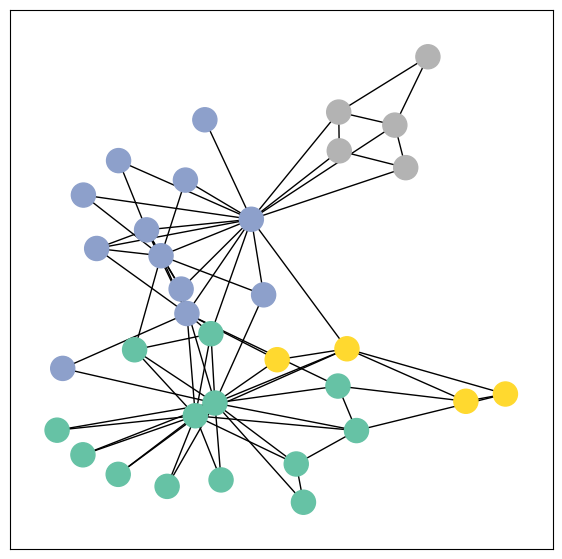

In [72]:
from torch_geometric.utils import to_networkx
print(f"y: {data.y}")

G = to_networkx(data, to_undirected=True)
visualization(G, color=data.y)

In [90]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, output_dim, edge_index):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.edge_index = edge_index
        self.gconv1 = GCNConv(input_dim, 4)
        self.gconv2 = GCNConv(4, 4)
        self.gconv3 = GCNConv(4, 2)
        self.clf = Linear(2, output_dim)
    def forward(self, X):
        h = self.gconv1(X, self.edge_index)
        h = torch.tanh(h)
        h = self.gconv2(h, self.edge_index)
        h = h.tanh()
        h = self.gconv3(h, self.edge_index)
        h = h.tanh()

        out = self.clf(h)
        return out, h

model = GCN(dataset.num_features, dataset.num_classes, data.edge_index)
print(model)

GCN(
  (gconv1): GCNConv(34, 4)
  (gconv2): GCNConv(4, 4)
  (gconv3): GCNConv(4, 2)
  (clf): Linear(in_features=2, out_features=4, bias=True)
)


In [91]:
lr = 1e-2
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 350

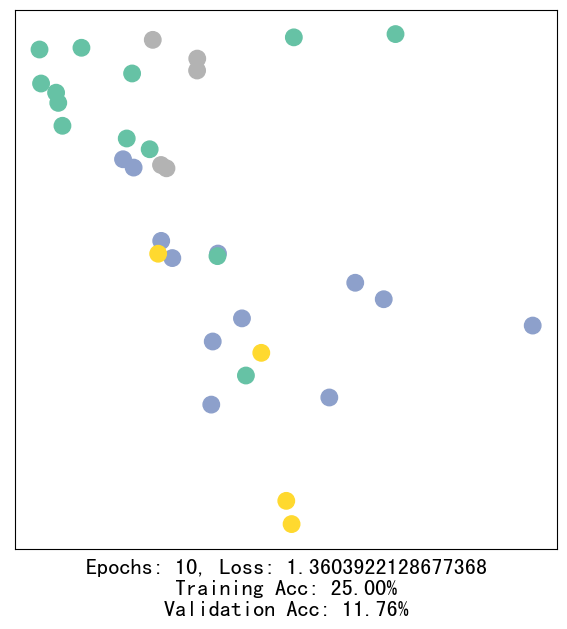

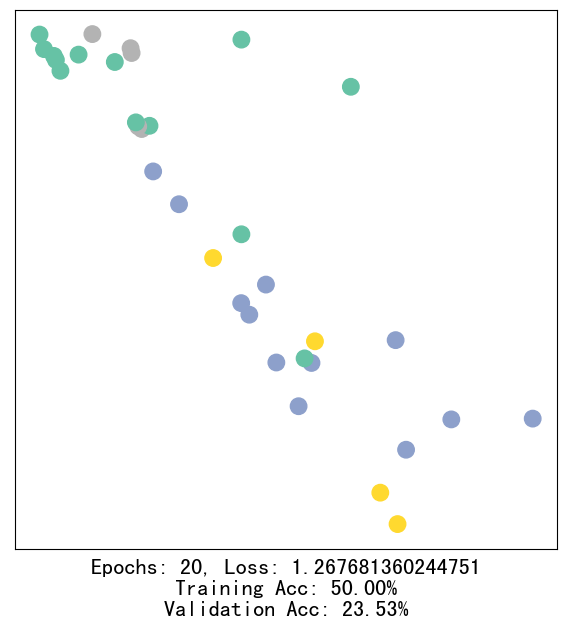

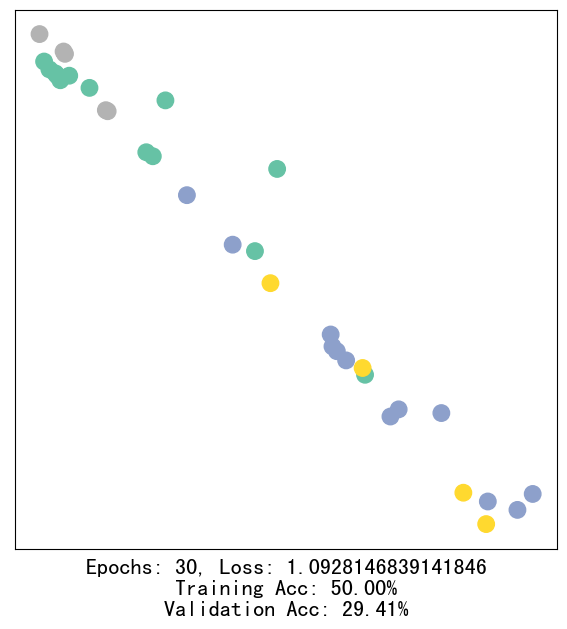

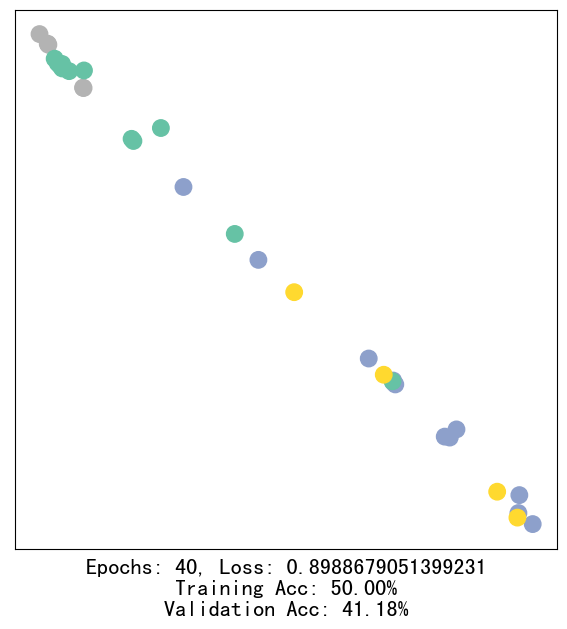

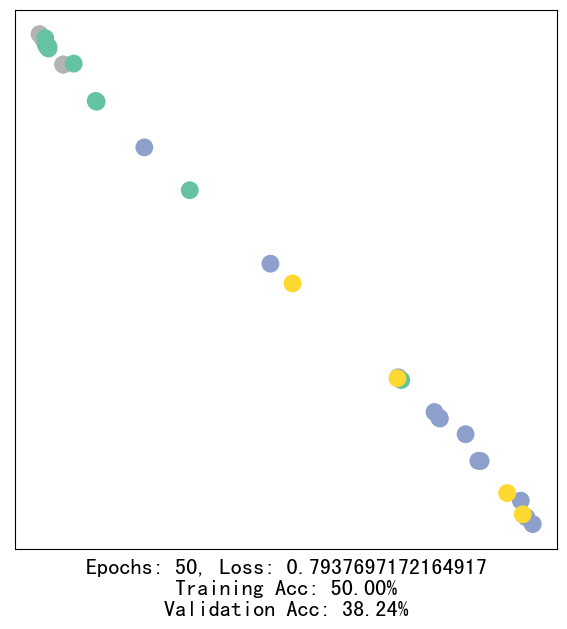

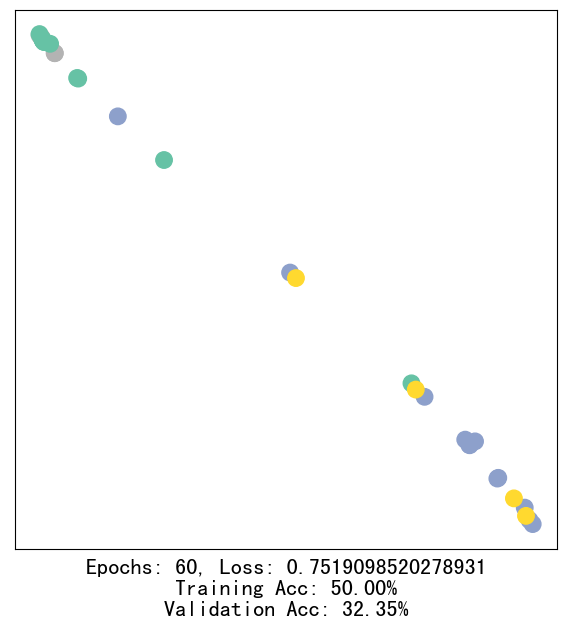

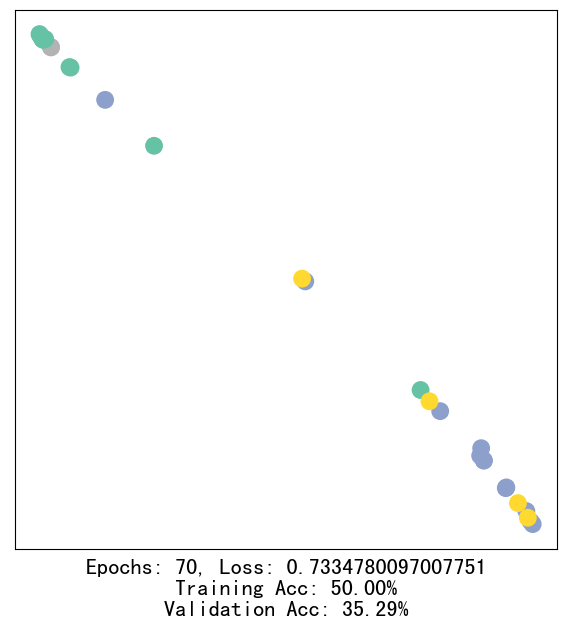

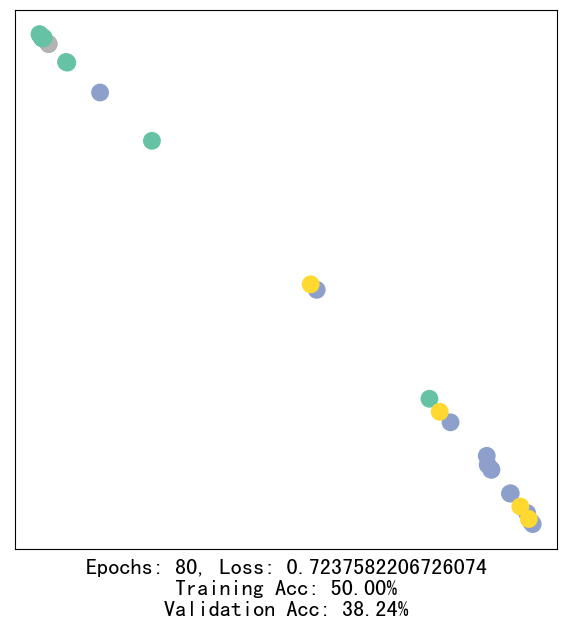

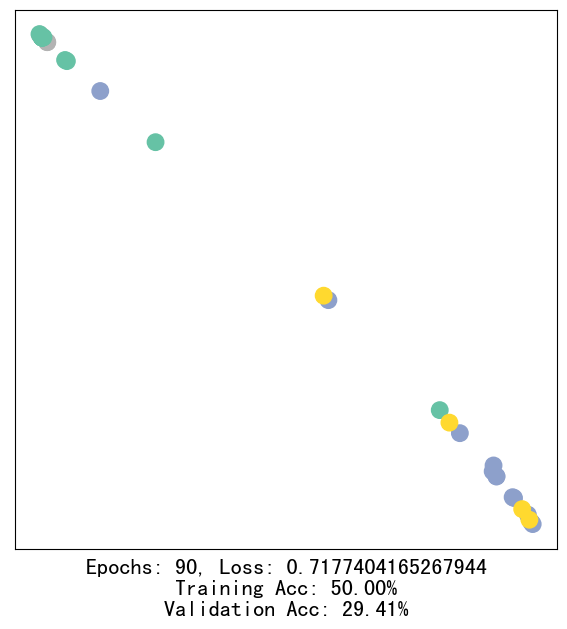

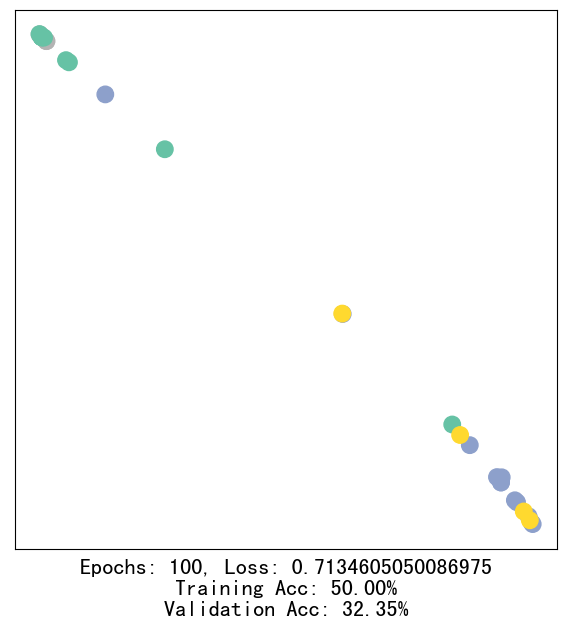

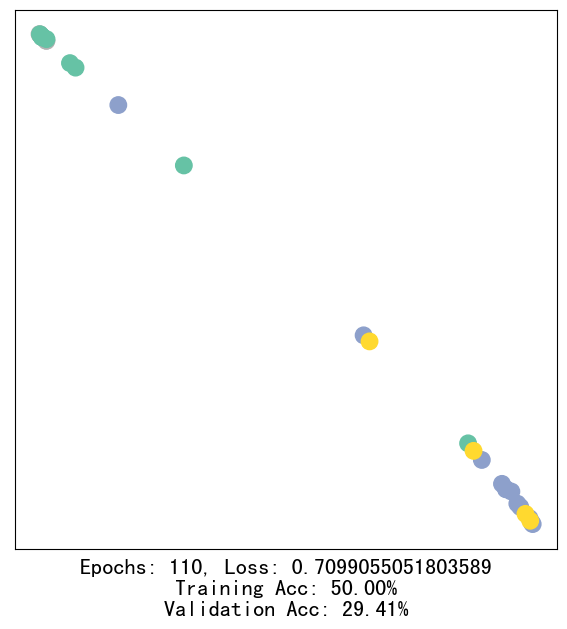

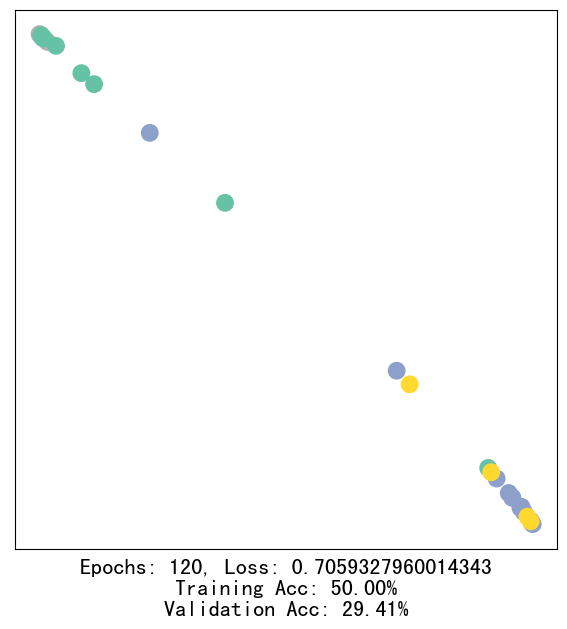

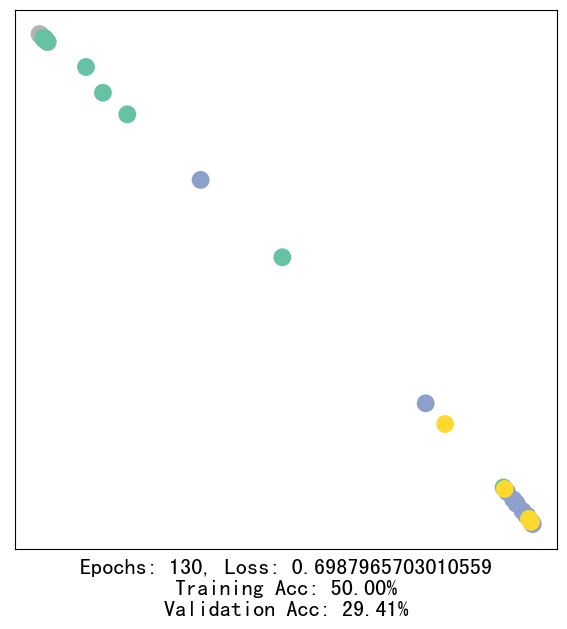

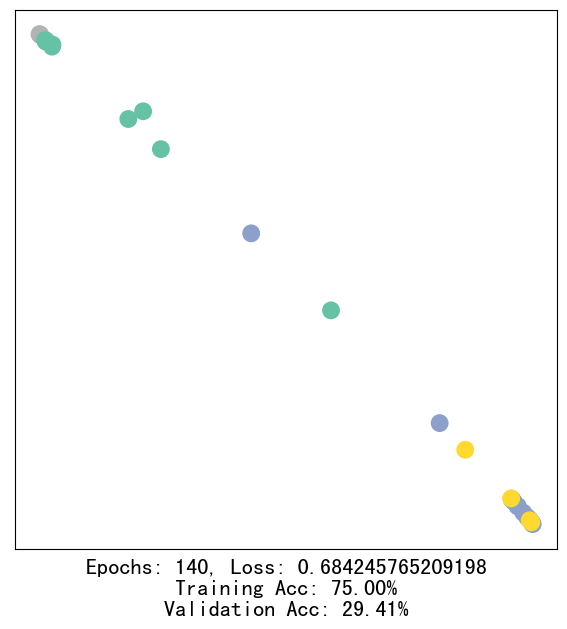

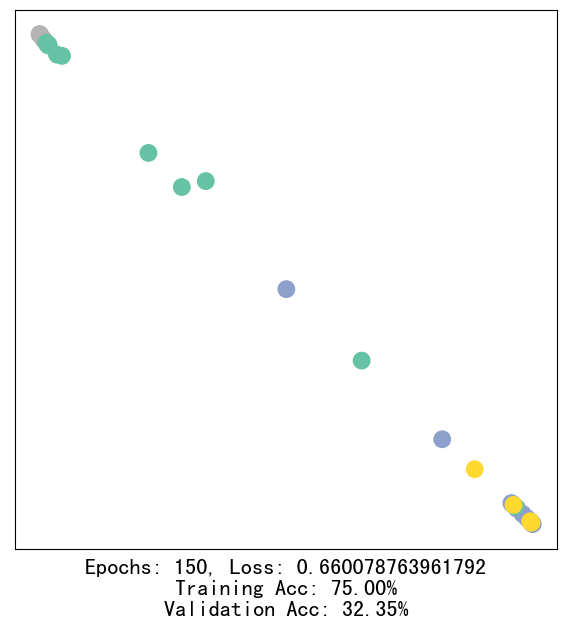

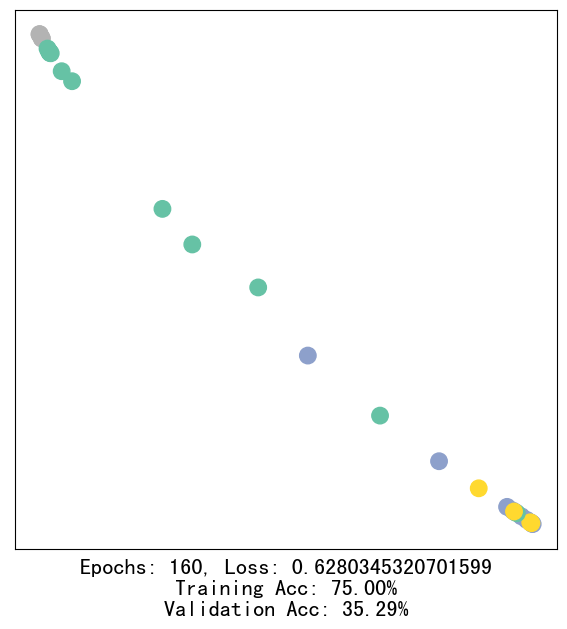

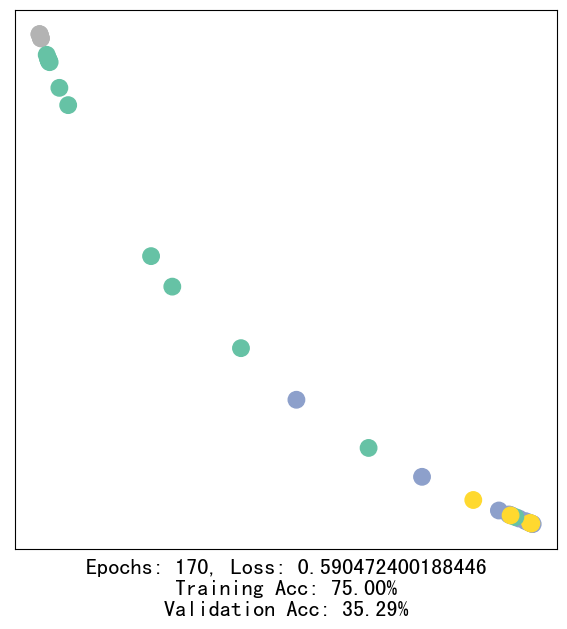

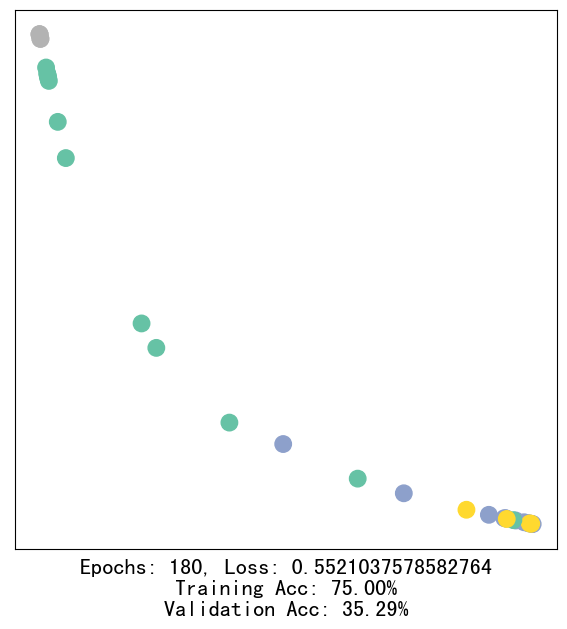

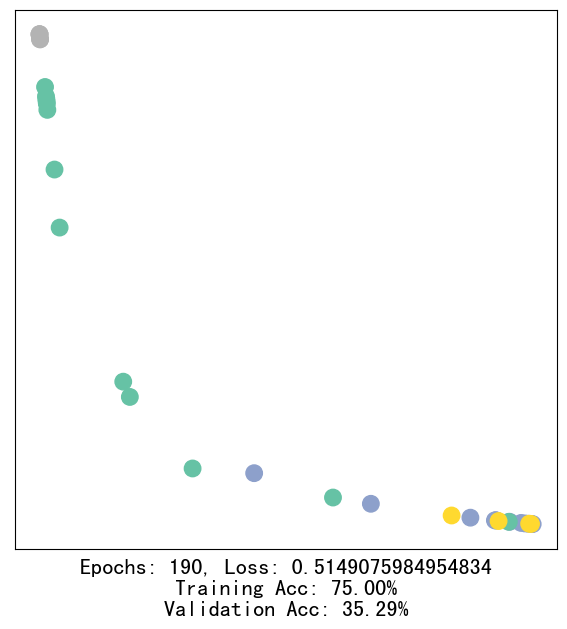

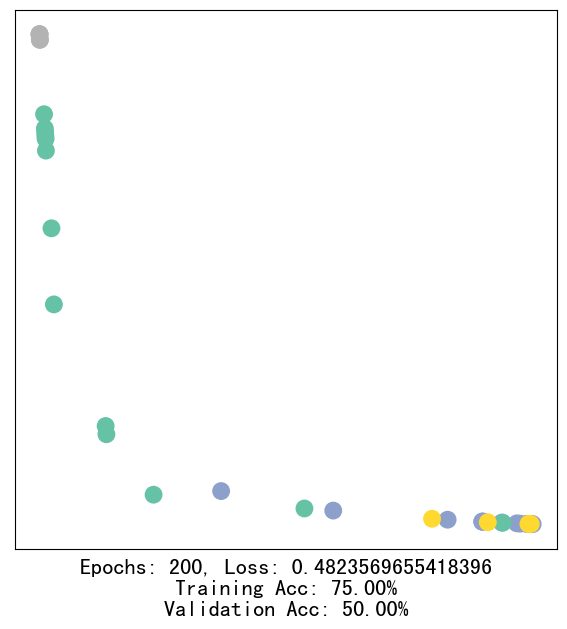

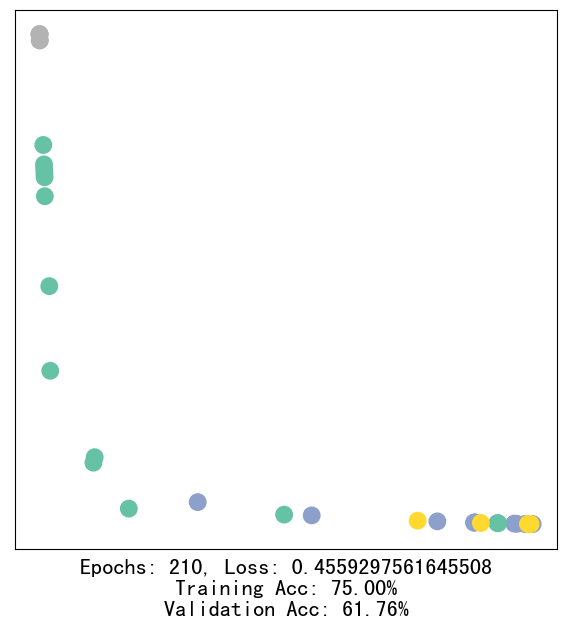

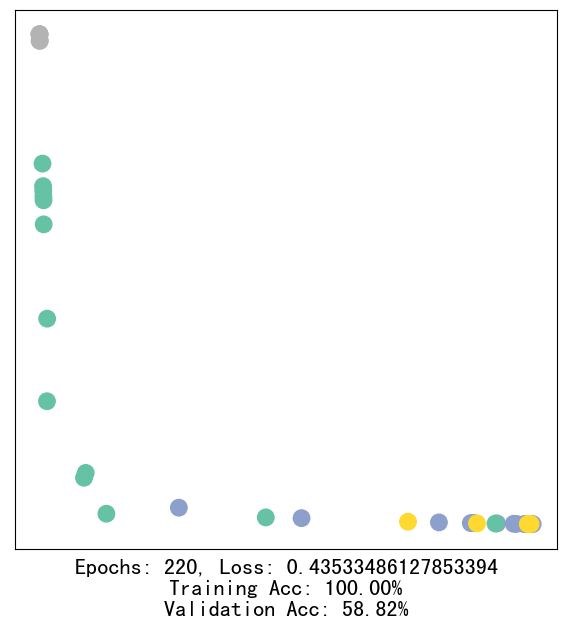

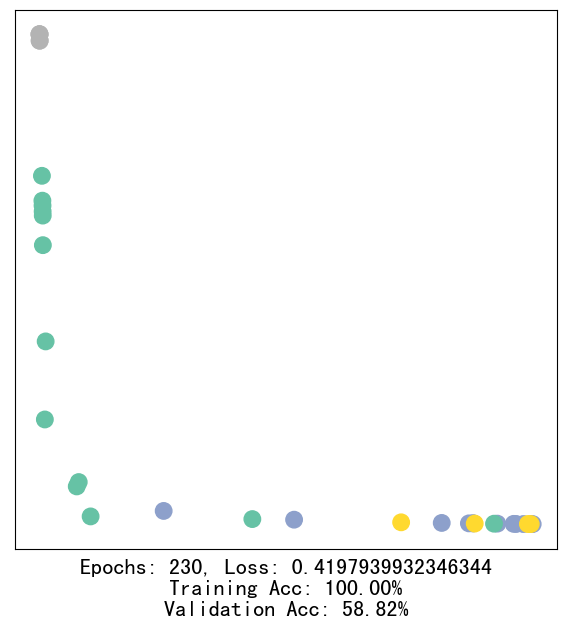

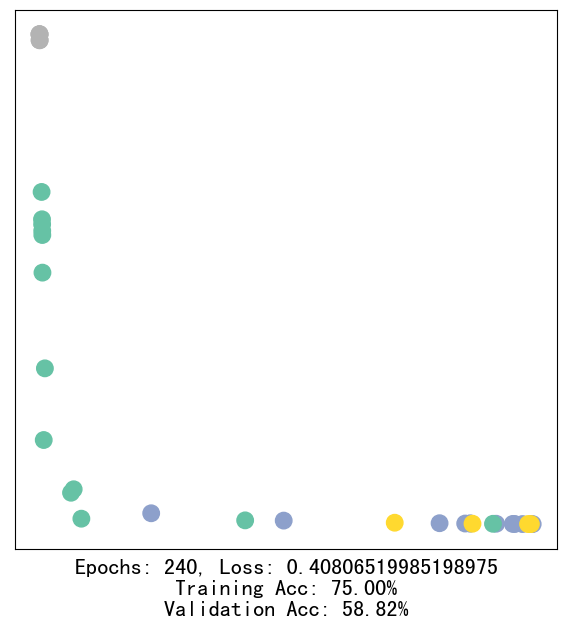

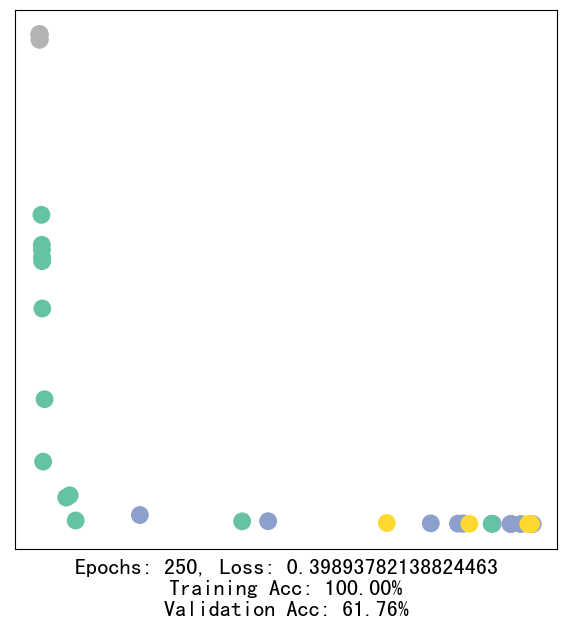

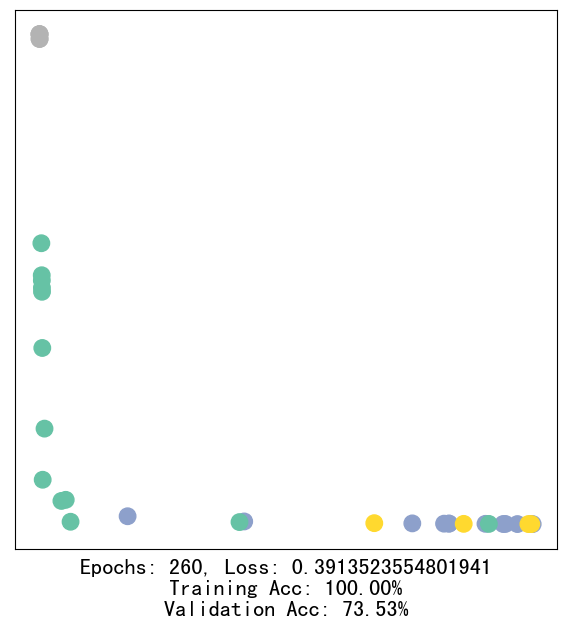

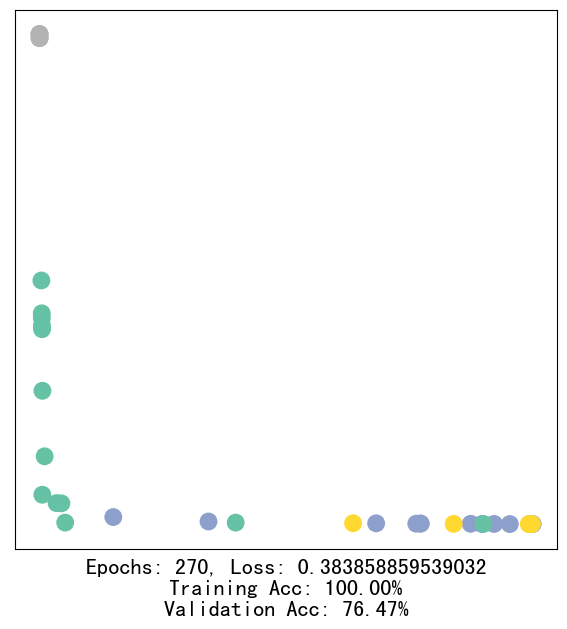

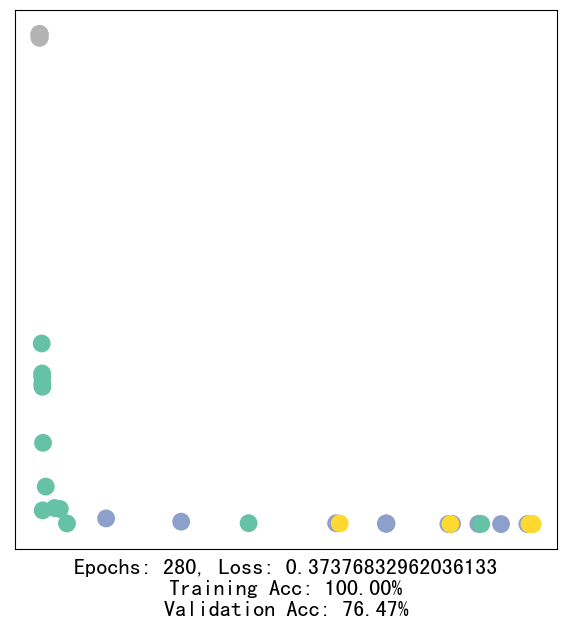

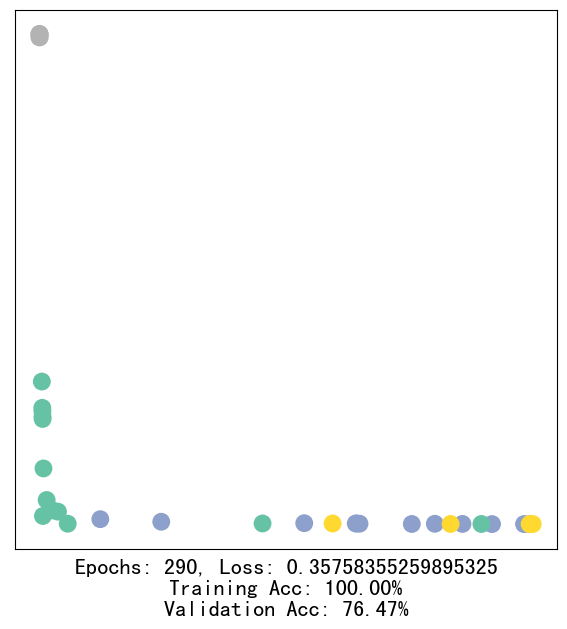

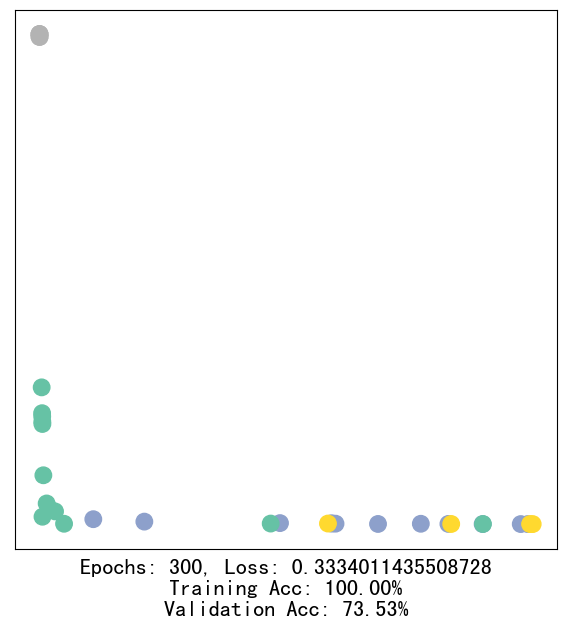

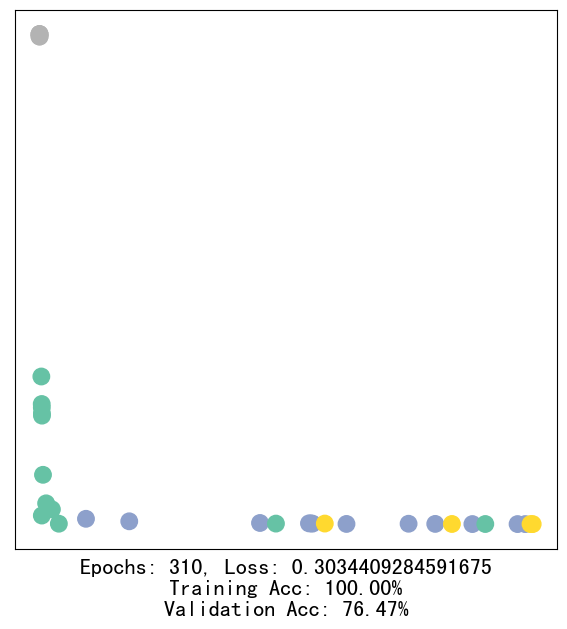

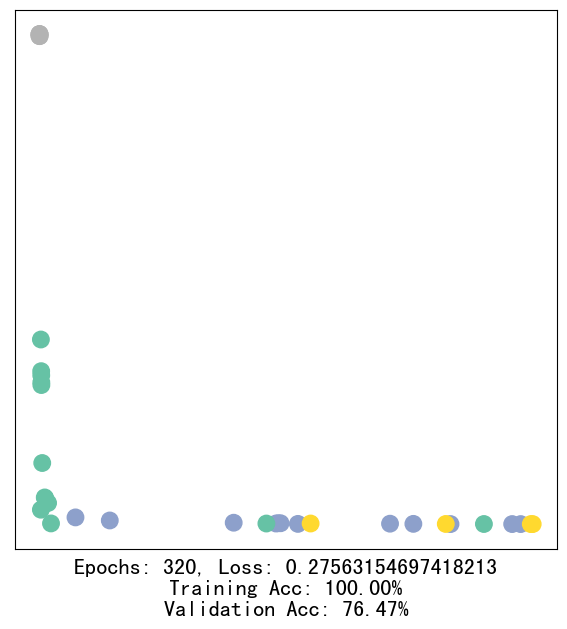

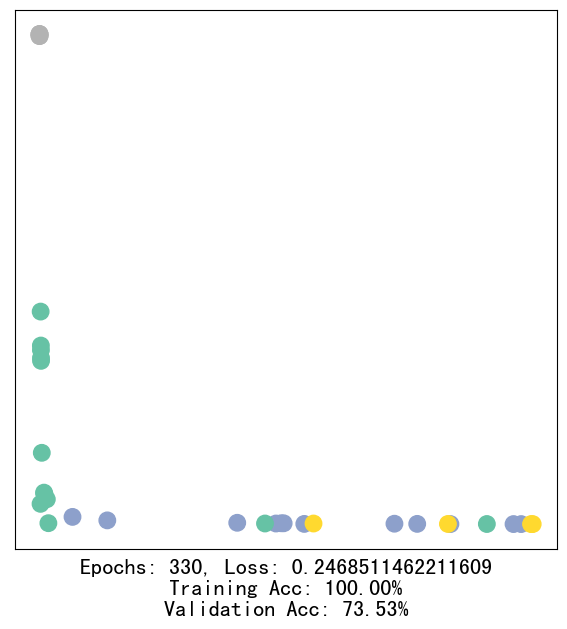

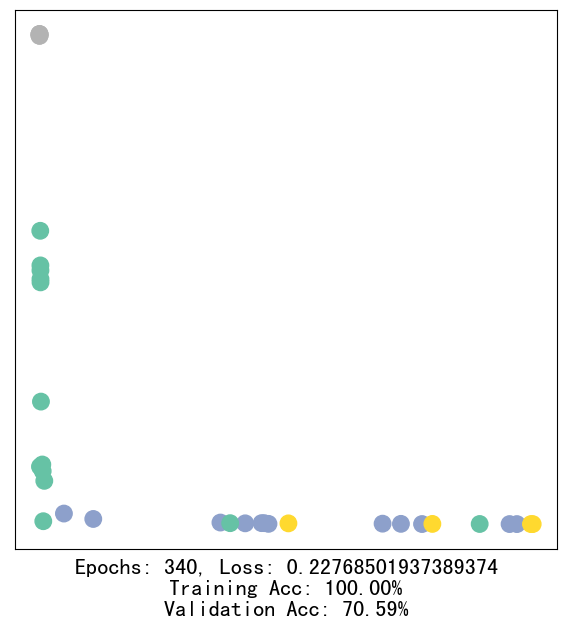

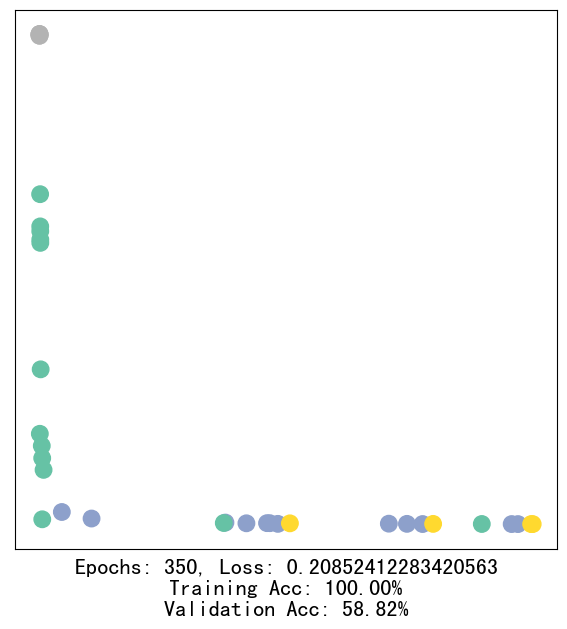

In [92]:
def train(data, model, optim, loss_fn):
    optim.zero_grad()
    out, h = model(data.x)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optim.step()

    accuracy = dict()
    accuracy['train'] = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum() / data.y[data.train_mask].shape[0]
    accuracy['val'] = (out.argmax(dim=1) == data.y).sum() / data.y.shape[0]

    return loss, accuracy, h

for i in range(1, epochs+1):
    loss, accuracy, h = train(data, model, optim, loss_fn)

    if i % 10 == 0:
        visualization(h, color=data.y, epochs=i, loss=loss, accuracy=accuracy)
